In [1]:
import math as mth
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random   
from scipy.sparse import csr_matrix
import networkx as nx
import os

In [31]:
#Zone di interesse (rappresentazione grafica)
r = 0.3
S=[0,1]  
I=[0,1]

#Zone di transizione, recupero, fatalità

P_SI=0.01 #Percentuale da suscettibili a infetti
s=0.2
S0=[s,s+P_SI*(S[-1]-S[0])]

P_IR=0.02 #Percentuale da infetti a guariti
s=0.5
R=[s,s+P_IR*(I[-1]-I[0])]

P_IF=0.02 #Percentuale da infetti a deceduti
s=0.4
F=[s,s+P_IF*(I[-1]-I[0])]

# Numero di individui del campione
M = 100000
# Numero di iterazioni per la simulazione
N = 500
# Coefficiente di proporzionalità k per il potenziale di infettività
k = 0.04

In [3]:
#Matrice sparsa di contagio
def generate_sparse_matrix(n_righe, n_colonne, m=5):

    # Genero gli indici di riga per inserire i k valori non nulli
    righe = np.repeat(np.arange(n_righe), m)        #Generiamo righe lunghe n_righe*m di elemnti da 0 a n_rows-1 ripetuto m volte

    colonne = np.empty(n_righe * m, dtype=np.int32) #Generiamo colonne lunghe n_righe*m di numeri casuali interi a 32 bit (per conservare memoria)                      

    for i in range(n_righe):
        n_colonne_corrette = np.delete(np.arange(n_colonne), i)
        #Generiamo un array di numeri casuali di lunghezza n_colonne in cui eliminiamo l'elemento dellìindice del ciclo
        colonne[i*m:(i+1)*m] = np.random.choice(n_colonne_corrette, size=m, replace=False)         
        #Selezioniamo m diversi elemnti delle colonne corrette senza ripetizioni e le salvo al posto delle colonne di indice [i*m:(i+1)*m]
                                                                                 
        #Creo quindi indici di riga e colonna a cui successivamente attribuisco valore 1 
   
    valori= np.ones(n_righe * m)

    return csr_matrix((valori, (righe, colonne)), shape=(n_righe, n_colonne))
    
#Traiettoria associata alla mappa
def Traiettoria(u, r):
    if u < r:
        return u / r
    else:
        return (1 - u) / (1 - r)



In [4]:
def K_operatore(x, y, A, r, k, S0, R, F):
    
    s=x.copy()
    t=y.copy()
    K=np.empty(M)
    contatore_infetti=np.zeros(M)

    for i in range(M):
        infettivi=[]        #Lista di infetti che possono infettare la persona i                               

                            # Considero solo gli stati suscettibili
        if y[i] == 0 and not (S0[0] <= x[i] < S0[1]):
                            # Estraggo dalla matrice gli indici con valore diverso da zero
            vicini=A[i].indices
                            # Cerco tra i vicini degli indici estratti quelli infettivi (y=1 e x in I)
            for n in vicini:
              if y[n]==1: #and not (R[0] <= x[n] < R[-1] or F[0] <= x[n] < F[-1]):  #Non tengo conto di R e F
                  infettivi.append(n)
                            # Verifico che la lista di infettivi non sia vuota per calcolare il fattore di infettività
            if infettivi:
                            # Calcolo l'operatore di infettività
                K[i]=k*max(x[l] for l in infettivi)
                            # Soglia di passaggio a infetto a causa di soggetti fuori dal network
                if x[i]+K[i]>1.0:
                    s[i]=x[i] + K[i] - 1.0
                    t[i]=1

                    contatore_infetti[i] = 1

    return s, t, contatore_infetti
    def Plot(υ):
    # Zone di interesse
    r = 0.3
    S = [0, 1]  
    I = [1, 2]

    # Zone di transizione, recupero, fatalità
    P_SI = 0.2
    s = 0.2
    S0 = [s, s + P_SI * (S[-1] - S[0])]

    P_IR = 0.2
    s = 1.5
    R = [s, s + P_IR * (I[-1] - I[0])]

    P_IF = 0.1
    s = 1.7
    F = [s, s + P_IF * (I[-1] - I[0])]

    
    plt.figure(figsize=(10,5))                            
    plt.ylim(-0.3, 2.1)
    lim = [-1, len(υ) + 5]
    plt.xlim(lim)

    # punti
    x, y = np.arange(len(υ)), υ
    plt.plot(x, y, 'o-', color='black', ms=3, lw=0.5)          

    # aree
    spess = 3                     
    mk = 0.1                       
    x = [lim[0], lim[0]]           
    displ = -len(υ)/50                    
    χ = x[0] + 0.1

    # Decessi
    plt.axvline(x=χ, ymin=ynorm(2), ymax=ynorm(3), color="black", lw=spess)
    plt.axhline(y=2, color='black')
    plt.text(x[0]+displ, 2.1, "Decessi", color="black", va="center")                

    # Infetti e Suscettibili
    plt.axvline(x=χ, ymin=ynorm(0), ymax=ynorm(2), color="red", lw=spess)
    plt.axhline(y=S0[0], color='blue')
    plt.axhline(y=S0[1], color='blue')
    plt.text(x[0]+displ, np.mean(S0), " (S0)", color="red", va="center", rotation=90)
    plt.text(x[0]+displ, np.mean([1, min(F[0], R[0])]), " (I)", color="red", va="center", rotation=90)

    # Guariti
    plt.axvline(x=χ, ymin=ynorm(R[0]), ymax=ynorm(R[1]), color="green", lw=spess)
    plt.axhline(y=R[0], color='green')
    plt.axhline(y=R[1], color='green')
    plt.text(x[0]+displ, np.mean(R), " (R)", color="green", va="center", rotation=90)
    plt.axvline(x=χ, ymin=ynorm(0), ymax=ynorm(S0[0]), color="blue", lw=spess)
    plt.axvline(x=χ, ymin=ynorm(S0[1]), ymax=ynorm(1), color="blue", lw=spess)
    plt.text(x[0]+displ, S0[0]/2, " (S)", color="blue", va="center", rotation=90)
    plt.text(x[0]+displ, (S0[1]+1)/2, "(S)", color="blue", va="center", rotation=90)

    # Deceduti
    plt.axvline(x=χ, ymin=ynorm(F[0]), ymax=ynorm(F[1]), color="gray", lw=spess)
    plt.axhline(y=F[0], color='gray')
    plt.axhline(y=F[1], color='gray')
    plt.text(x[0]+displ, np.mean(F), " (F)", color="gray", va="center", rotation=90)

    # Immunità
    plt.plot(lim[0], [0], 'o', color='purple', ms=spess, lw=spess)
    plt.axhline(y=0, color='purple')
    plt.text(x[0]+3*displ, 0, "Imm", color="purple", va="center")

    # Stabilità
    plt.axhline(y=1, color='orange')
    plt.text(x[0]+displ, 1.02, "=", color="orange", va="center")

    # Generalità             
    plt.title(f'Andamento Epidemico - {min(len(υ), N)} Iterazioni, z0={υ[0]:.4f}')
    plt.xlabel('Iterazioni (n)')
    plt.ylabel('(z)')
    plt.yticks([])
    plt.tight_layout()                                              
    plt.savefig("Graf1.png", dpi=200, bbox_inches="tight")           
    plt.show()

def ynorm(y):
  ymin,ymax=-0.3, 2.1
  return (y - ymin) / (ymax - ymin)


In [6]:
#Costruiamo una matrice sparsa
A=generate_sparse_matrix(M, M)

#Condizioni iniziali M soggetti tutti suscettibili
x=np.random.rand(M)
y=np.zeros(M, dtype=np.int8)           
x_next=np.empty(M)
y_next=np.zeros(M, dtype=np.int8)

#creo una lista di valori da aggiorna delle z
z_n=[]
# Seleziono un individuo randomicamente
individuo=np.random.randint(M)

# Creo istogrammi associati a ogni regione
S_hist,I_hist,S0_hist,R_hist,F_hist,K_hist=np.empty(N),np.empty(N),np.empty(N),np.empty(N),np.empty(N),np.empty(N)

#Avvio un ciclo su tutte le iterazioni
for n in range(N):

#Avvio un ciclo su tutti i soggetti
  for i in range(M):
    x_next[i]=Traiettoria(x[i], r)
    if y[i] == 0:  # Suscettibili
      y_next[i] = 1 if S0[0] <= x[i] < S0[-1] else 0
    else:          # Infetti
      y_next[i] = 0 if R[0] <= x[i] < R[-1] or F[0] <= x[i] < F[-1] else 1

#Aggiorno le condizioni del sogetto i-esimo
    x[i],y[i]=x_next[i], y_next[i]

#Applico K alle nuove posizioni
  x, y, contatore_infetti=K_operatore(x, y, A, r, k, S0, R, F)

#Trovo z in funzione di n per un certo individuo
  z_n.append(x[individuo]+y[individuo])

#per ogni iterazione vedo come variano i dati
  in_K=(contatore_infetti == 1)
  in_S=(y == 0)
  in_I=(y == 1)
  in_S0=in_S & (x >= S0[0]) & (x < S0[-1])
  in_R=in_I & (x >= R[0]) & (x < R[-1])
  in_F=in_I & (x >= F[0]) & (x < F[-1])

  S_hist[n] = in_S.mean()
  I_hist[n] = in_I.mean()
  S0_hist[n] = in_S0.mean()
  R_hist[n] = in_R.mean()
  F_hist[n] = in_F.mean()
  K_hist[n] = in_K.mean()

#per controllare
print(f"Ultime frazioni: S={S_hist[-1]:.3f}, I={I_hist[-1]:.3f}, R={R_hist[-1]:.3f}, F={F_hist[-1]:.3f}, K={K_hist[-1]:.3f}")

Ultime frazioni: S=0.465, I=0.535, R=0.012, F=0.008, K=0.013


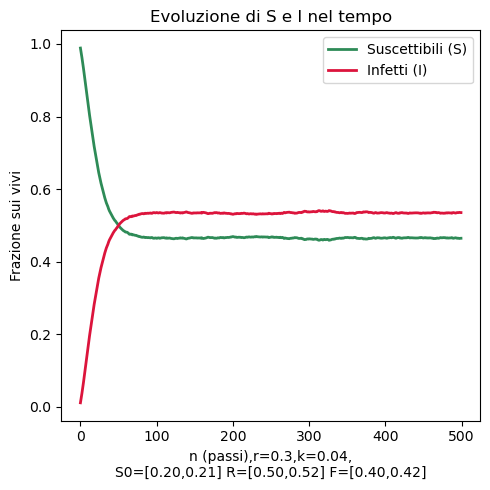

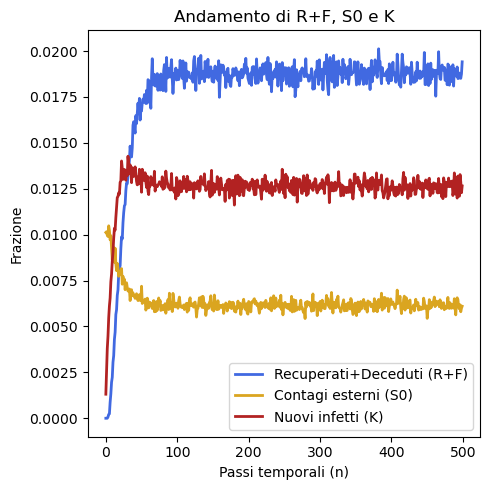

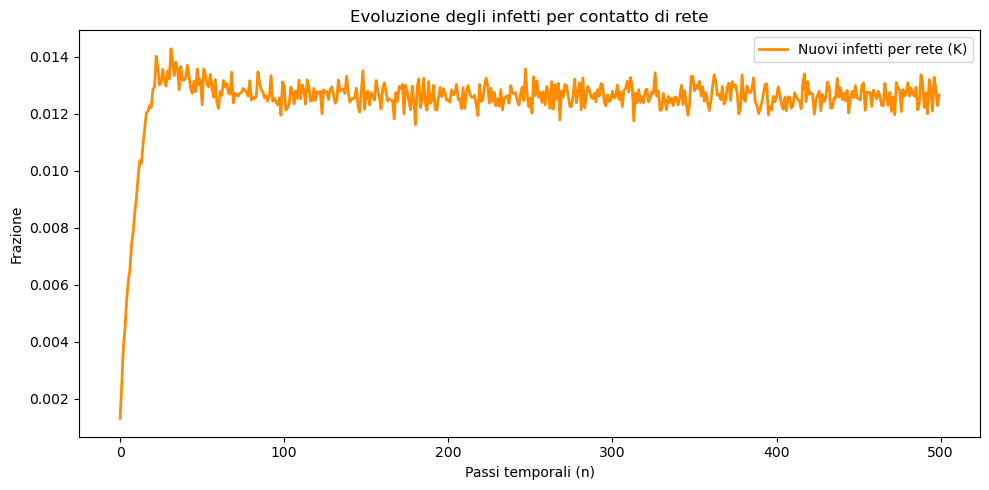

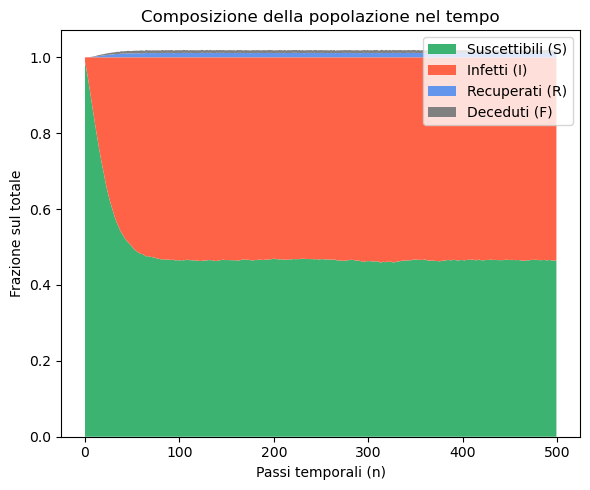

In [45]:
t = np.arange(N)

# Confronto tra le due curve S ed I
plt.figure(figsize=(5, 5))
plt.plot(t, S_hist, label="Suscettibili (S)", lw=2, color="seagreen")
plt.plot(t, I_hist, label="Infetti (I)", lw=2, color="crimson")
plt.xlabel(f"n (passi),r={r},k={k},\nS0=[{S0[0]:.2f},{S0[-1]:.2f}] R=[{R[0]:.2f},{R[-1]:.2f}] F=[{F[0]:.2f},{F[-1]:.2f}]")
plt.ylabel("Frazione sui vivi")
plt.title("Evoluzione di S e I nel tempo")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Confronto S e I.png")
plt.show()

# Confronto tra R+F, S0 e K
plt.figure(figsize=(5, 5))
plt.plot(t, R_hist + F_hist, label="Recuperati+Deceduti (R+F)", lw=2, color="royalblue")
plt.plot(t, S0_hist, label="Contagi esterni (S0)", lw=2, color="goldenrod")
plt.plot(t, K_hist, label="Nuovi infetti (K)", lw=2, color="firebrick")
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione")
plt.title("Andamento di R+F, S0 e K")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Curva n vs stati.png")
plt.show()

# Curva K(n)
plt.figure(figsize=(10, 5))
plt.plot(t, K_hist, label="Nuovi infetti per rete (K)", lw=2, color="darkorange")
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione")
plt.title("Evoluzione degli infetti per contatto di rete")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("Curva n vs infetti.png")
plt.show()

# Distribuzioni aree di S, I, R e F
plt.figure(figsize=(6, 5))
plt.stackplot(
    t, S_hist, I_hist, R_hist, F_hist,
    labels=["Suscettibili (S)", "Infetti (I)", "Recuperati (R)", "Deceduti (F)"],
    colors=["mediumseagreen", "tomato", "cornflowerblue", "gray"]
)
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione sul totale")
plt.title("Composizione della popolazione nel tempo")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Distribuzioni aree.png")
plt.show()


In [9]:
S=S_hist[-1]
S0=S0_hist[-1]
I=I_hist[-1]
R=R_hist[-1]
F=F_hist[-1]
K=K_hist[-1]

α=S0_hist[-1]/S_hist[-1]
β=(R_hist[-1]+F_hist[-1])/I_hist[-1]
γ=K_hist[-1]/(S_hist[-1]*I_hist[-1])

#per controllare
print(f"Ultime frazioni: S={S_hist[-1]:.3f}, I={I_hist[-1]:.3f}, R={R_hist[-1]:.3f}, F={F_hist[-1]:.3f}, K={K_hist[-1]:.3f}")

print(f"Ultime frazioni: α={S0_hist[-1]/S_hist[-1]:.3f}, β={(R_hist[-1]+F_hist[-1])/I_hist[-1]:.3f}, γ={K_hist[-1]/(S_hist[-1]*I_hist[-1]):.3f}")

Δ=(α+β-γ)**2+4*γ*α
J,Iinf=((α+β-γ)+(Δ)**0.5)/(-2*γ),((α+β-γ)-(Δ)**0.5)/(-2*γ)
print(f'Iinf={Iinf:.3f},J={J:.3f}')

Ultime frazioni: S=0.465, I=0.535, R=0.012, F=0.008, K=0.013
Ultime frazioni: α=0.013, β=0.036, γ=0.051
Iinf=0.523,J=-0.494


In [ ]:
Plot(z_n)